## **Partie IV: Interpretation du modele de prediction**

##

### **Sommaire**

**1- Importation des donnees**<br />

&emsp;1.1  Intallation des librairies<br />
&emsp;1.2  Importation des librairies<br />
&emsp;1.3  Importation donnees<br />
&emsp;&emsp;1.3.1  Caracteristiques des donnees d'entrainement <br />
&emsp;&emsp;1.3.2  Caracteristiques des donnees test<br />
&emsp;&emsp;1.3.3  Analyse de la Variable à expliquer(predictive)<br />

**2- Construction du modèle LightGBM**<br />
&emsp;2.1 Serialisation du modele LightGBM<br />
&emsp;2.2 Features importances<br />

**3. Interpretation du modele**<br />
&emsp;3.1 Application du max_scorer<br />
&emsp;3.2 Apprentissage d'un  modele avec le nouveau score <br />
&emsp;3.3 Seuil optimal en validation <br />
&emsp;3.4 probabilite sur le jeux de test<br />

**4. Evaluation - ROC**<br />
&emsp;4.1 Métriques avec le seuil optimisé<br />

**5. Interprétabilité - SHAP  et Feature Importances**<br />
&emsp;5.1 Feature Importance globale<br />
&emsp;5.2 SHAP – interprétabilité locale et globale<br />
&emsp;5.3 Visualiser l'interprétabilité globale<br />
&emsp;5.4 Visualisation l'interprétabilité locale<br />

**6. Prediction sur l'ensemble de test avec le seuil optimise**<br />
&emsp;6.1 Appliquer SHAP sur les données de test<br />
&emsp;6.2 Interpretation des resultats du client 15


#####

#####

#### 1.1 Intallation des librairies

#### 1.2  Importation des librairies

In [1]:
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

# Visualisation
import seaborn as sns
from xplotter.insights import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 6, 4

sns.set_style("ticks")
sns.color_palette("pink", as_cmap=True)

# Modélisation
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap


pd.set_option('display.float_format', '{:,.2f}'.format)

# pour ne pas imprimer les warnings
warnings.filterwarnings('ignore')

# version des librairies utilisées
import sys
print("python version", sys.version)
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version :", sns.__version__)
print("sklearn version :", sklearn.__version__)
print("lightgbm version :", lgb.__version__)
print("shap version :", shap.__version__)

c:\Users\HP\Documents\projet 7\P7_cloud_deploiement\env_cloud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


python version 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
pandas version : 2.2.3
numpy version : 2.2.4
matplotlib version : 3.10.1
seaborn version : 0.13.2
sklearn version : 1.6.1
lightgbm version : 4.6.0
shap version : 0.47.2


#### 1.3 Importation des données

In [81]:
# Chemin du fichier 
path_test = r"C:\Users\HP\Documents\projet 7\Deploiement_Projet7\modele\notebook\test_tracking.csv"
path_train = r"C:\Users\HP\Documents\projet 7\Deploiement_Projet7\modele\notebook\train_tracking.csv"

# transformation en dataframe
X_test = pd.read_csv(path_test)
df_train =pd.read_csv(path_train)

# Séparation des features (X) et de la variable cible (y)
X = df_train.drop(columns='TARGET')
y0 = df_train['TARGET']
y = pd.DataFrame(y0)

# Séparation de l'ensemble X_train en 2 sous-ensembles
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.3, stratify=y, random_state=42)

X_train.shape,X_test.shape, X_valid.shape, y_valid.shape, y_train.shape

((215257, 83), (48744, 83), (92254, 83), (92254, 1), (215257, 1))

1.4 Caracteristiques des donnees d'entrainement 

In [82]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,"215,257.00","169,084.26","274,245.23","25,650.00","112,500.00","148,500.00","202,500.00","117,000,000.00"
AMT_CREDIT,"215,257.00","599,416.43","402,647.71","45,000.00","270,000.00","516,397.50","808,650.00","4,050,000.00"
AMT_ANNUITY,"215,257.00","27,116.88","14,549.70","1,615.50","16,524.00","24,903.00","34,587.00","258,025.50"
NAME_EDUCATION_TYPE,"215,257.00",1.51,0.87,0.00,1.00,1.00,2.00,4.00
DAYS_BIRTH,"215,257.00",43.93,11.96,21.00,34.00,43.00,54.00,69.00
DAYS_EMPLOYED,"215,257.00",-174.86,387.17,"-1,001.00",1.00,3.00,8.00,48.00
FLAG_WORK_PHONE,"215,257.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
FLAG_PHONE,"215,257.00",0.28,0.45,0.00,0.00,0.00,1.00,1.00
CNT_FAM_MEMBERS,"215,257.00",2.15,0.91,1.00,2.00,2.00,3.00,20.00
REGION_RATING_CLIENT,"215,257.00",0.95,0.51,0.00,1.00,1.00,1.00,2.00


In [83]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215257 entries, 159703 to 301908
Data columns (total 83 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   AMT_INCOME_TOTAL                         215257 non-null  float64
 1   AMT_CREDIT                               215257 non-null  float64
 2   AMT_ANNUITY                              215257 non-null  float64
 3   NAME_EDUCATION_TYPE                      215257 non-null  float64
 4   DAYS_BIRTH                               215257 non-null  float64
 5   DAYS_EMPLOYED                            215257 non-null  float64
 6   FLAG_WORK_PHONE                          215257 non-null  int64  
 7   FLAG_PHONE                               215257 non-null  int64  
 8   CNT_FAM_MEMBERS                          215257 non-null  float64
 9   REGION_RATING_CLIENT                     215257 non-null  float64
 10  REGION_RATING_CLIENT_W_CITY     

1.5 Caracteristiques des donnees test

In [84]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,"48,744.00","178,431.81","101,522.59","26,941.50","112,500.00","157,500.00","225,000.00","4,410,000.00"
AMT_CREDIT,"48,744.00","516,740.44","365,397.00","45,000.00","260,640.00","450,000.00","675,000.00","2,245,500.00"
AMT_ANNUITY,"48,744.00","29,424.65","16,012.58","2,295.00","17,973.00","26,199.00","37,390.50","180,576.00"
NAME_EDUCATION_TYPE,"48,744.00",1.54,0.89,0.00,1.00,1.00,3.00,4.00
DAYS_BIRTH,"48,744.00",44.01,11.85,20.00,34.00,43.00,54.00,69.00
DAYS_EMPLOYED,"48,744.00",-184.96,395.61,"-1,001.00",1.00,4.00,8.00,48.00
FLAG_WORK_PHONE,"48,744.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
FLAG_PHONE,"48,744.00",0.26,0.44,0.00,0.00,0.00,1.00,1.00
CNT_FAM_MEMBERS,"48,744.00",2.15,0.89,1.00,2.00,2.00,3.00,21.00
REGION_RATING_CLIENT,"48,744.00",0.96,0.52,0.00,1.00,1.00,1.00,2.00


In [85]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 83 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   AMT_INCOME_TOTAL                         48744 non-null  float64
 1   AMT_CREDIT                               48744 non-null  float64
 2   AMT_ANNUITY                              48744 non-null  float64
 3   NAME_EDUCATION_TYPE                      48744 non-null  float64
 4   DAYS_BIRTH                               48744 non-null  float64
 5   DAYS_EMPLOYED                            48744 non-null  float64
 6   FLAG_WORK_PHONE                          48744 non-null  int64  
 7   FLAG_PHONE                               48744 non-null  int64  
 8   CNT_FAM_MEMBERS                          48744 non-null  float64
 9   REGION_RATING_CLIENT                     48744 non-null  float64
 10  REGION_RATING_CLIENT_W_CITY              48744

1.6 Analyse de la Variable à expliquer(predictive)

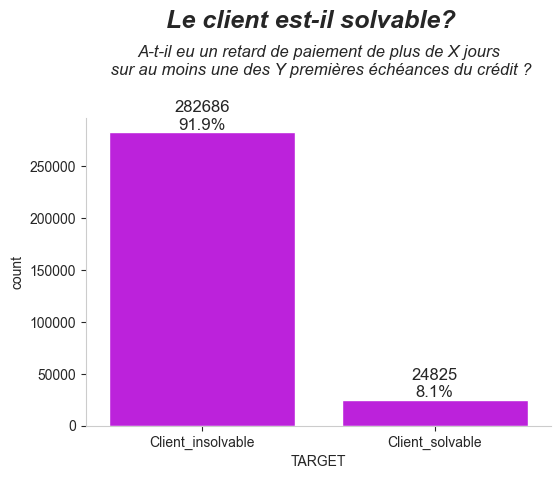

In [86]:
from xplotter.insights import *

colors = ['#d103fa']
loan_map = {1 : "Client_solvable",
            0 : "Client_insolvable"}

fig, ax = plt.subplots(figsize=(6, 4))
plot_countplot(df=y, 
               col='TARGET', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.suptitle("Le client est-il solvable?\n",
             y=1.15, fontsize=18, fontstyle='italic', fontweight = 'bold')
plt.title("A-t-il eu un retard de paiement de plus de X jours\n sur au moins une des Y premières échéances du crédit ?\n\n",
           loc="center", fontsize=12, fontstyle='italic')
plt.show()

#### **II- Construction du modèle LightGBM**

In [88]:
# Nettoyage des colonnes pour LightGBM
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

clf = LGBMClassifier(objective="binary",
                            class_weight="balanced",
                            verbose=-1,
                            boosting_type="gbdt",
                            n_estimators=623,
                            learning_rate=0.010901700721791268,
                            max_depth=-1,
                            num_leaves=100,                           
                            min_child_samples=64,    
                            subsample= 0.5076510213913661,                    
                            colsample_bytree=0.5236243943211537,
                            random_state=101,
                            n_jobs=-2)
model = clf.fit(X_train, y_train)

2.1 Serialisation du modele LightGBM

In [89]:
# Sauvegarde du modèle
import pickle
pickle.dump(model, open('C:/Users/HP/Documents/projet 7/P7_cloud_deploiement/model.pkl', 'wb'))

2.2 Features importances

In [90]:
# importance des variables
importance = pd.DataFrame({'variable': X_train.columns,
                                 'coef': model.feature_importances_})
# importance = importance.sort_values(by='coef', ascending=False)
print(importance)


                           variable  coef
0                  AMT_INCOME_TOTAL  2000
1                        AMT_CREDIT  3442
2                       AMT_ANNUITY  3480
3               NAME_EDUCATION_TYPE   875
4                        DAYS_BIRTH  2809
..                              ...   ...
78  NAME_TYPE_SUITE_Group_of_people     0
79          NAME_TYPE_SUITE_Other_A     2
80          NAME_TYPE_SUITE_Other_B     4
81   NAME_TYPE_SUITE_Spouse_partner    75
82    NAME_TYPE_SUITE_Unaccompanied   169

[83 rows x 2 columns]


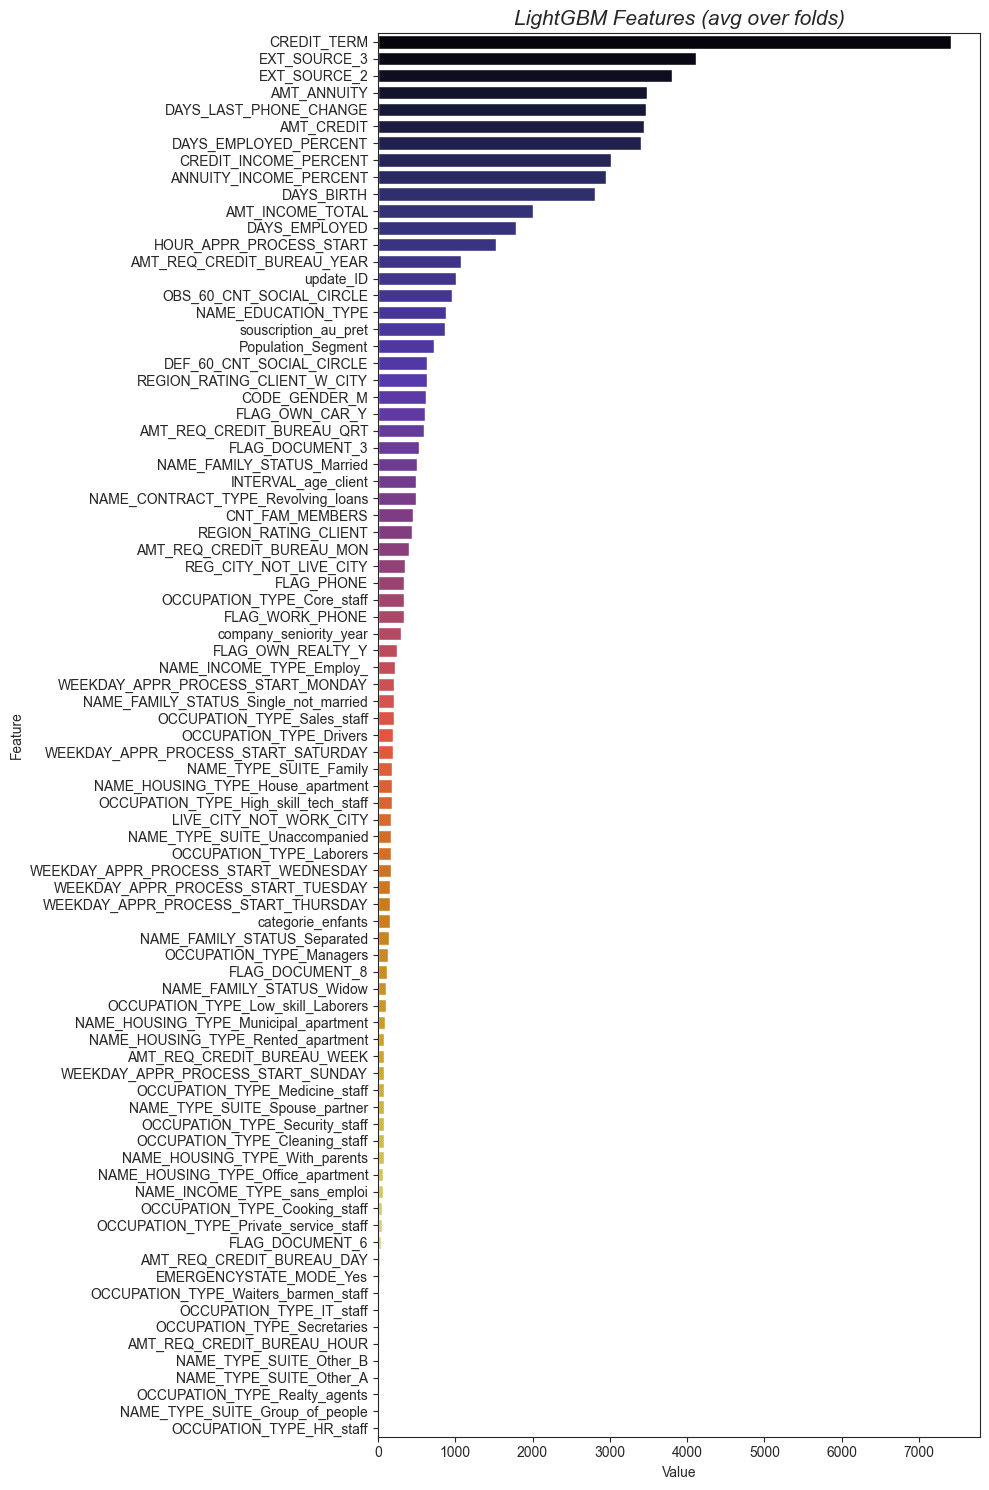

In [91]:
sns.set_style("ticks")

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 15))
sns.barplot(x="Value", y="Feature", 
            data=feature_imp.sort_values(by="Value", ascending=False),
            palette="CMRmap")
plt.title('LightGBM Features (avg over folds)', fontsize=15, fontstyle='italic')
plt.tight_layout()
plt.show()

##### **III- Fonction de coût métier**
Cette fonction permet de trouver le seuil optimal qui minimise la perte métier

3.1 Application du max_scorer

In [98]:
from sklearn.metrics import make_scorer, confusion_matrix
import numpy as np

# Fonction de coût métier
def cost_function(y_true, y_pred_proba, seuil=0.5):
    y_pred = (y_pred_proba >= seuil).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn * 10 + fp * 1
    return -cost  # pour maximiser dans GridSearchCV

# Scorer compatible avec sklearn
custom_scorer = make_scorer(
    lambda y_true, y_pred_proba: cost_function(y_true, y_pred_proba, seuil=0.5),
    greater_is_better=True,
    needs_proba=True
)

3.2 Apprentissage d'un  modele avec le nouveau score 

In [99]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# parametre
param_grid = {
    "n_estimators": [50, 150],
    "max_depth": [3, 5, 7]
}

# Grid Search avec custom_scorer
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring=custom_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Score coût minimum (négatif):", -grid_search.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Meilleurs hyperparamètres : {'max_depth': 3, 'n_estimators': 50}
Score coût minimum (négatif): nan


3.3 Seuil optimal en validation

In [100]:
# Probabilités sur validation
best_model = grid_search.best_estimator_
y_val_proba = best_model.predict_proba(X_valid)[:, 1]

seuils = np.linspace(0.0, 1.0, 100)
couts = []

for seuil in seuils:
    y_val_pred = (y_val_proba >= seuil).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_val_pred).ravel()
    cout = fn * 10 + fp * 1
    couts.append(cout)

# Trouver le seuil optimal
seuil_optimal = seuils[np.argmin(couts)]
cout_minimal = np.min(couts)

print(f"Seuil optimal : {seuil_optimal:.3f}")
print(f"Coût métier minimal : {cout_minimal}")


Seuil optimal : 0.515
Coût métier minimal : 53326


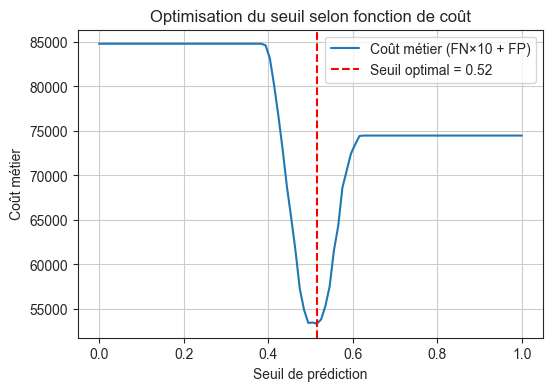

In [143]:
plt.figure(figsize=(6,4))
plt.plot(seuils, couts, label="Coût métier (FN×10 + FP)")
plt.axvline(seuil_optimal, color='red', linestyle='--', label=f"Seuil optimal = {seuil_optimal:.2f}")
plt.xlabel("Seuil de prédiction")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil selon fonction de coût")
plt.legend()
plt.grid()
plt.show()


3.4 probabilite sur le jeux de test

In [103]:
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= seuil_optimal).astype(int)

submission = pd.DataFrame({
    "TARGET_PREDICTED": y_test_pred,
    "PROBA": y_test_proba
})
submission 


,TARGET_PREDICTED,PROBA
0,1,0.52
1,1,0.54
2,0,0.41
3,0,0.46
4,1,0.53
...,...,...
48739,0,0.42
48740,0,0.48
48741,0,0.50
48742,0,0.46


##### **4. Evaluation - ROC**

In [104]:
# Probabilités sur jeu de validation
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

# Prédictions avec le seuil optimisé
y_valid_pred = (y_valid_proba >= seuil_optimal).astype(int)

4.1 Métriques avec le seuil optimisé

In [107]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

# ROC AUC classique (ne dépend pas du seuil)
roc_auc = roc_auc_score(y_valid, y_valid_proba)

# F1, Précision, Rappel avec prédictions seuilées
f1 = f1_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)

# Matrice de confusion
tn, fp, fn, tp = confusion_matrix(y_valid, y_valid_pred).ravel()

# Coût métier total
cout_metier = fn * 10 + fp * 1

In [135]:
print("===== Évaluation du modèle =====")
print(f"ROC AUC            : {roc_auc:.4f}")
print(f"F1-Score           : {f1:.4f}")
print(f"Précision          : {precision:.4f}")
print(f"Rappel             : {recall:.4f}")
print(f"Faux Positifs (FP) : {fp}")
print(f"Faux Négatifs (FN) : {fn}")
print(f"Coût métier total  : {cout_metier} (fonction FN×10 + FP×1)")


===== Évaluation du modèle =====
ROC AUC            : 0.7255
F1-Score           : 0.2597
Précision          : 0.1693
Rappel             : 0.5576
Faux Positifs (FP) : 20376
Faux Négatifs (FN) : 3295
Coût métier total  : 53326 (fonction FN×10 + FP×1)


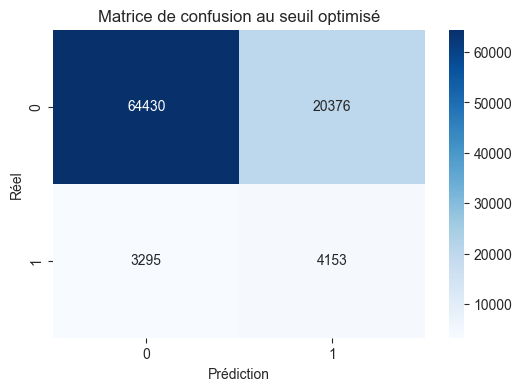

In [109]:
cf_matrix = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion au seuil optimisé")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()


##### 5. Interprétabilité - SHAP  et Feature Importances

l’interprétabilité, pour expliquer pourquoi modèle décide ainsi<br/>


5.1 Feature Importance globale

In [110]:
importances = best_model.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(10))

                        Feature  Importance
15                 EXT_SOURCE_3         101
14                 EXT_SOURCE_2          93
3           NAME_EDUCATION_TYPE          28
4                    DAYS_BIRTH          26
56                CODE_GENDER_M          21
36                  CREDIT_TERM          15
29          INTERVAL_age_client          12
10  REGION_RATING_CLIENT_W_CITY          10
5                 DAYS_EMPLOYED           9
19              FLAG_DOCUMENT_3           6


In [117]:
feature_importance_seuil_optimal = feature_importance_df[feature_importance_df["Importance"] > 0]
feature_importance_seuil_optimal

,Feature,Importance
15,EXT_SOURCE_3,101
14,EXT_SOURCE_2,93
3,NAME_EDUCATION_TYPE,28
4,DAYS_BIRTH,26
56,CODE_GENDER_M,21
36,CREDIT_TERM,15
29,INTERVAL_age_client,12
10,REGION_RATING_CLIENT_W_CITY,10
5,DAYS_EMPLOYED,9
19,FLAG_DOCUMENT_3,6


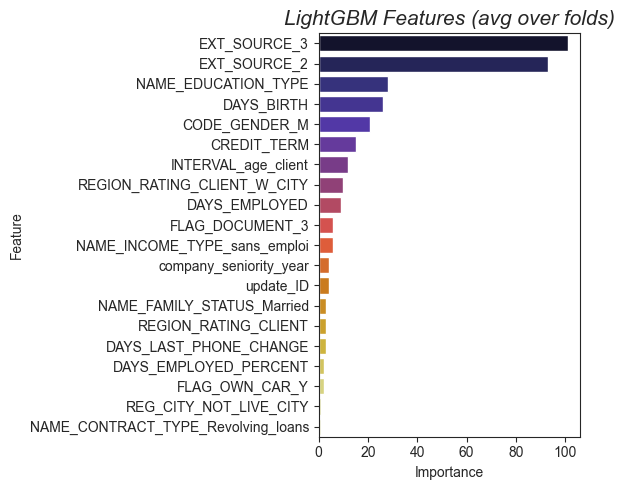

Ces features sont les variables qui influencent globalement  le modèle


In [144]:
sns.set_style("ticks")

plt.figure(figsize=(6, 5))
sns.barplot(x="Importance", y="Feature", 
            data=feature_importance_seuil_optimal.sort_values(by="Importance", ascending=False),
            palette="CMRmap")
plt.title('LightGBM Features (avg over folds)', fontsize=15, fontstyle='italic')
plt.tight_layout()
plt.show()
print("Ces features sont les variables qui influencent globalement  le modèle")

#### 5.2   SHAP – interprétabilité locale et globale

SHAP va te permettre d'expliquer chaque prédiction client (**"Pourquoi ce client a été accepté/refusé ?"**)

Comprendre globalement comment le modèle fonctionne

In [128]:
# Créer l'explainer pour LightGBM
explainer = shap.TreeExplainer(best_model)

# Calculer les SHAP values sur X_valid
shap_values = explainer.shap_values(X_valid)

##### 5.3 Visualiser l'interprétabilité globale
Ceci permet de vue globale de l'impact de toutes les variables

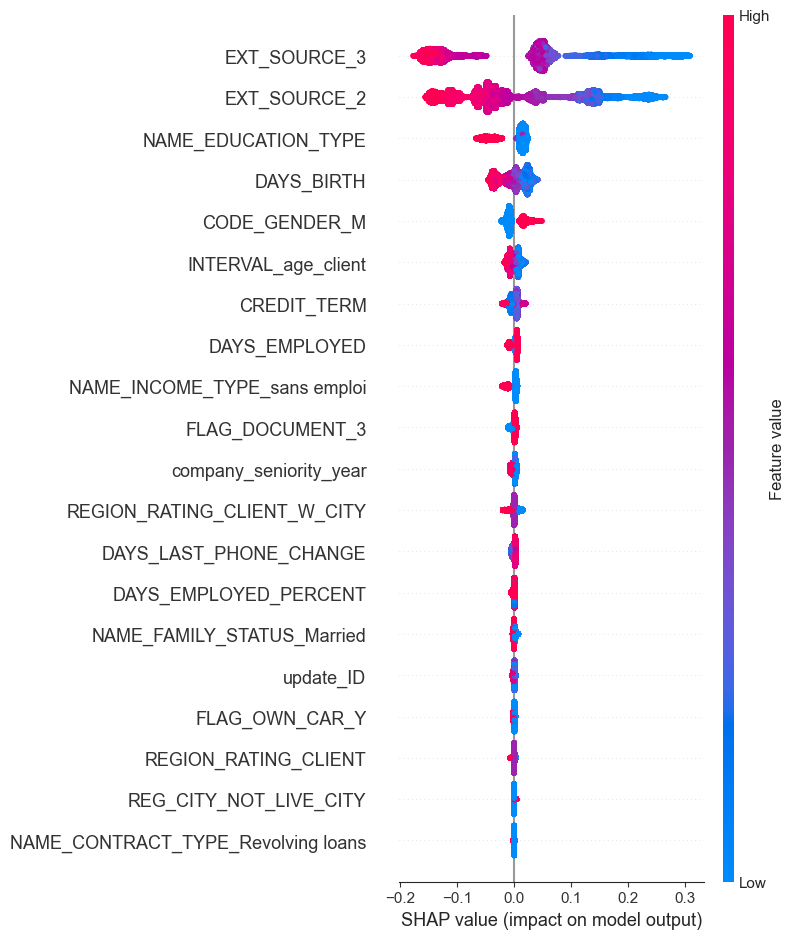

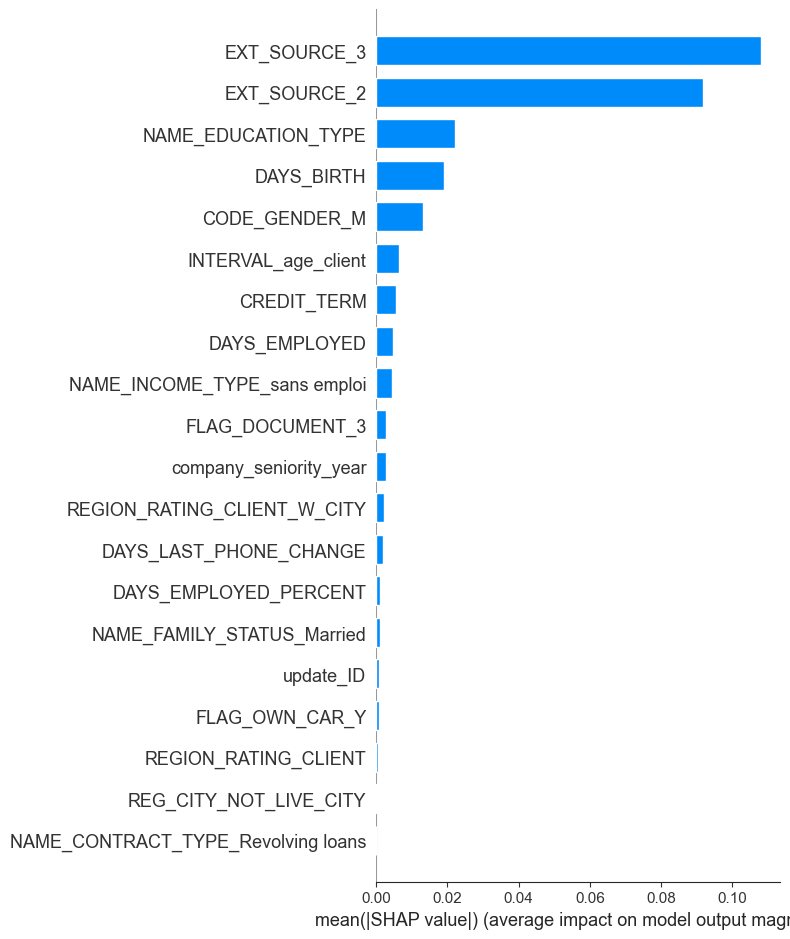

In [130]:
shap.summary_plot(shap_values, X_valid)
shap.summary_plot(shap_values, X_valid, plot_type="bar")

##### 5.4 Visualisation l'interprétabilité locale

ceci montre comment chaque feature pousse la prédiction vers "défaut" ou "non défaut"

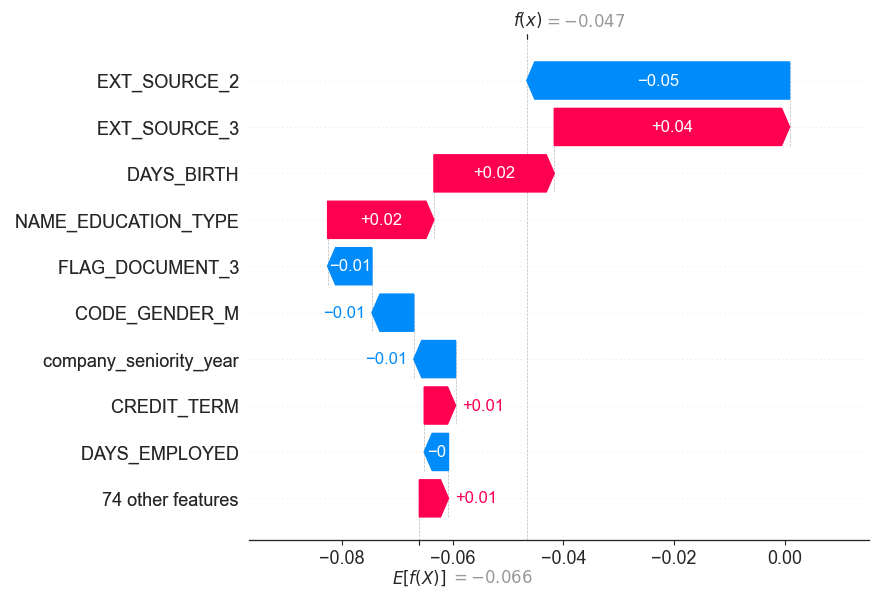

In [ ]:
# Exemple pour le client numéro 15 de X_valid
client_id = 15

# Force plot
shap.force_plot(
    explainer.expected_value, 
    shap_values[client_id], 
    X_valid.iloc[client_id]
)

# Waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, 
    shap_values[client_id], 
    X_valid.iloc[client_id]
)


####

#### 6.  Prediction sur l'ensemble de test avec le seuil optimise

In [139]:
# Probabilite sur les donnees test
y_test_proba = best_model.predict_proba(X_test)[:, 1]
# prediction sur les donnees test
y_test_pred = (y_test_proba >= seuil_optimal).astype(int)

6.1 Appliquer SHAP sur les données de test

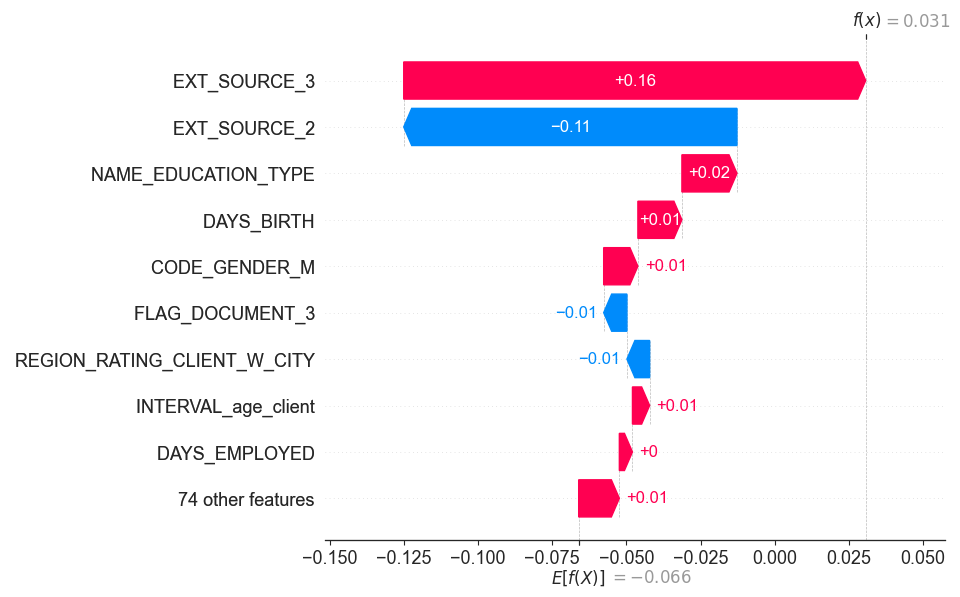

In [ ]:
# Créer l'explainer pour LightGBM
explainer = shap.TreeExplainer(best_model)
# Calculer les SHAP values sur les donnees test
shap_values_test = explainer.shap_values(X_test)


# Exemple pour le client numéro 15 de X_valid
client_id = 15

# Force plot
shap.force_plot(
    explainer.expected_value, 
    shap_values_test[client_id], 
    X_test.iloc[client_id]
)

# Waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, 
    shap_values_test[client_id], 
    X_test.iloc[client_id]
)


##### 6.2 Interpretation des resultats du client 15

**E[f(X)] = -0.066**:	Moyenne des prédictions du modèle (cela correspond à un client "standard")<br />
**f(x) = -0.047**:	Score prédit pour ce client<br />
**Barres rouges**:	Variables qui augmentent le score de défaut<br />
**Barres bleues**:	Variables qui diminuent le score de défaut<br />

##### Score prédit pour le client 15: **-0.047** 
- Le score de ce client 15 est **plus élevé que la moyenne**, donc :<br />
Le **modèle estime que ce client est légèrement plus risqué que la moyenne**.

- le modèle estime que ce client a un risque légèrement supérieur à la moyenne.<br />
Toutefois, le score reste négatif, donc probablement acceptable selon le seuil métier.<br />

##### **Point de vue metier**
Ce client a un score de risque légèrement supérieur au client moyen, principalement<br /> 
à cause de son âge, son niveau d’éducation, et un score externe (EXT_SOURCE_3) défavorable.<br /> 
Cependant, son ancienneté, les documents fournis, et EXT_SOURCE_2 jouent un rôle rassurant.